In [1]:
add = "D:\phd\\0 term 1\AAV\FinalProject\codes and tools\\final"

In [2]:
import glob

In [ ]:
files = glob.glob(add+'/*.txt', 
                   recursive = True)
for file in files:
    fl = open(file, 'r')
    data = fl.readlines()
    fl.close()
    for dt in data:
        print(dt)

In [6]:
add = "D:\phd\\0 term 1\\AAV\FinalProject\label"

In [8]:
import os

In [10]:
files = glob.glob(add+'/*.txt', 
                   recursive = True)

In [12]:
image  = glob.glob(add+'/*.png', 
                   recursive = True)

In [ ]:
image

In [18]:
imgs = []
for i in image:
    imgs.append(i.split("\\")[-1].split(".png")[0])

In [ ]:
imgs

In [ ]:
for i in files:
    name = i.split("\\")[-1].split(".txt")[0]
    if name in imgs:
        print(name)

In [22]:
for img in (imgs):
    if img not in (files):
        os.remove('D:\\phd\\0 term 1\\AAV\\FinalProject\\label\\'+img+'.png')


In [24]:
address= "D:\\phd\\0 term 1\\AAV\\FinalProject\\label\\"

In [39]:
add_iamges = address+"images"
add_labels = address+"labels"
X = os.listdir(add_iamges)
y = os.listdir(add_labels)

In [ ]:
len(X),len(y)

In [41]:
imagesssss = []
for i in X:
    imagesssss.append(i.split(".png")[0])

In [42]:
labelssss = []
for i in y:
    labelssss.append(i.split(".txt")[0])

In [43]:
for i in imagesssss:
    if i not in labelssss:
        os.remove(os.path.join(add_iamges,i+".png"))

## Test for accurate object position

In [ ]:
Drone_State = {'ts': 1738169426097965568, 
               'position': [98.0, 45.0, -5.9599289894104], 
               'orientation': <scipy.spatial.transform._rotation.Rotation object at 0x00000201203F56B0>, 
               'linear_velocity': [2.1093940461014427e-07, -2.1204215272518923e-07, -7.147600990720093e-05],
                'angular_velocity': [4.797804535883188e-07, 6.73798297157191e-08, 1.1432097629660021e-10], 
                'linear_acceleration': [4.712780210525125e-08, -7.511699777751346e-07, 0.0], 'has_collided': 0
                }

In [335]:
from ultralytics import YOLO

# Load a model
model = YOLO("D:/Lectures/Robot/final/FinalProject-v2/codes and tools/models/best.pt")
results = model("D:/Lectures/Robot/final/FinalProject-v2/codes and tools/final/20_rgb.png")



image 1/1 D:\Lectures\Robot\final\FinalProject-v2\codes and tools\final\20_rgb.png: 352x640 1 car, 35.5ms
Speed: 4.0ms preprocess, 35.5ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)


In [356]:
def detect_objects(image):
    results = model(image)
    detections = []
    for box in results[0].boxes:
        cls_id = int(box.cls)
        if model.names[cls_id] in ['person', 'car', 'airplane', 'bus'] and box.conf > .60: 
            print(box.conf)
            detections.append({
                'bbox': box.xyxy[0].tolist(),
                'class': model.names[cls_id]
            })
    return detections

In [357]:
detected_objects = []
rgb_img = "D:\Lectures\Robot\\final\FinalProject-v2\codes and tools\\notebooks\\rgb_img1.png"
detections = detect_objects(rgb_img)


image 1/1 D:\Lectures\Robot\final\FinalProject-v2\codes and tools\notebooks\rgb_img1.png: 352x640 2 cars, 71.5ms
Speed: 5.0ms preprocess, 71.5ms inference, 5.0ms postprocess per image at shape (1, 3, 352, 640)
tensor([0.8459], device='cuda:0')


In [358]:
detections

[{'bbox': [296.308349609375,
   232.91859436035156,
   354.4544372558594,
   259.6830749511719],
  'class': 'car'}]

In [339]:
results[0].show()

In [84]:
# for result in results:
#     boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes (convert to numpy array)
#     confidences = result.boxes.conf.cpu().numpy()  # Confidence scores
#     class_ids = result.boxes.cls.cpu().numpy().astype(int)
#     class_labels = [model.names[cls_id] for cls_id in class_ids]

In [85]:
# boxes

array([[     388.49,      255.25,       416.3,      311.12]], dtype=float32)

In [ ]:
Dron Pos:  [-107.1527099609375, -50.22417068481445, -34.608821868896484]
Dron ori:  [-3.24801317e-05  1.28950613e-04 -6.74300761e-01  7.38456814e-01]



# real_pos : [-98,-81,-2]



In [13]:
from PIL import Image
from scipy.spatial.transform import Rotation as R
import numpy as np
import cv2

In [200]:
def load_calibration_data(calibration_file):
    calibration = np.load(calibration_file)
    calibration_data = {
        'camera_matrix': calibration['camera_matrix'],
        'dist_coeffs': calibration['dist_coeffs'],
        'rvecs': calibration['rvecs'],
        'tvecs': calibration['tvecs']
    }
    return calibration_data

def undistorted_imgs(rgb_img, depth_img, calibration_data):
    undistorted_rgb = cv2.undistort(rgb_img, 
                                    calibration_data['camera_matrix'], 
                                    calibration_data['dist_coeffs'], 
                                    None, 
                                    calibration_data['camera_matrix'])
    
    undistorted_depth = cv2.undistort(depth_img, 
                                    calibration_data['camera_matrix'], 
                                    calibration_data['dist_coeffs'], 
                                    None, 
                                    calibration_data['camera_matrix'],
                                    flags=cv2.INTER_NEAREST)
    
    return undistorted_rgb, undistorted_depth
    
def compute_camera_world_position(drone_position, drone_orientation_quat):
    R_drone = R.from_quat(drone_orientation_quat).as_matrix()
    
    pitch_angle_rad = np.radians(-25)
    R_pitch = R.from_euler('x', pitch_angle_rad).as_matrix()
    
    camera_relative_body = np.array([0, 0, 0.24])
    camera_position_world = drone_position + R_drone @ camera_relative_body
    
    R_camera = R_drone @ R_pitch
    
    return camera_position_world, R_camera

def calculate_object_location(bbox, depth_image, intrinsic_matrix, camera_position, camera_orientation):
    x_min, y_min, x_max, y_max = bbox
    u_center = int((x_min + x_max) / 2)
    v_center = int((y_min + y_max) / 2)
    
    # meadina of depth for rmove noises
    depth_roi = depth_image[v_center-2:v_center+2, u_center-2:u_center+2]
    valid_depths = depth_roi[(depth_roi > 0) & (depth_roi <= 80)]
    if len(valid_depths) == 0:
        raise ValueError("No valid depth values")
    depth = np.median(valid_depths)
    
    # intrinsic_matrix parameters
    fx = intrinsic_matrix[0, 0]
    fy = intrinsic_matrix[1, 1]
    cx = intrinsic_matrix[0, 2]
    cy = intrinsic_matrix[1, 2]
    
    # Normalize cordinate (NED modify cordinate for Y)
    x_norm = (u_center - cx) / fx
    y_norm = -(v_center - cy) / fy  
    
    camera_coords = np.array([x_norm * depth, y_norm * depth, depth])
    
    world_coords = camera_orientation @ camera_coords + camera_position
    
    world_coords[2] = -world_coords[2]
    
    return world_coords

img = cv2.imread("D:/Lectures/Robot/final/FinalProject-v2/codes and tools/notebooks/rgb_img.png", cv2.IMREAD_UNCHANGED)

calibration_data = load_calibration_data("D:/Lectures/Robot/final/FinalProject-v2/cam_calib/camera_calibration.npz")

drone_pos = [-107.1527099609375, -50.22417068481445, -34.608821868896484]
drone_orientation_quat = [-3.24801317e-05,  1.28950613e-04, -6.74300761e-01,  7.38456814e-01]
bounding_box = [     388.49,      255.25,       416.3,      311.12]



depth_img = cv2.imread("D:/Lectures/Robot/final/FinalProject-v2/codes and tools/notebooks/depth_img.png", cv2.IMREAD_UNCHANGED)
print("Depth: ", depth_img.shape, (np.min(depth_img), np.max(depth_img)))
# depth_image = process_depth_image(depth_img)

camera_world, R_bc = compute_camera_world_position(drone_pos, drone_orientation_quat)

camera_orientation_matrix = R.from_matrix(R_bc).as_matrix()

world_cordinate = calculate_object_location(
                bbox= bounding_box,
                depth_image=depth_img,
                intrinsic_matrix=calibration_data['camera_matrix'],
                camera_position=camera_world,
                camera_orientation=camera_orientation_matrix
            )

Depth:  (367, 722) (34, 80)


In [201]:
world_cordinate

array([    -102.42,     -56.268,     -13.344])

In [ ]:
print('rgb_img: ', img)
print('=' *15)
print('depth_img: ', np.max(depth_img))

In [14]:
depth_img = cv2.imread("D:/Lectures/Robot/final/FinalProject-code/codes and tools/notebooks/rgb_img.png")

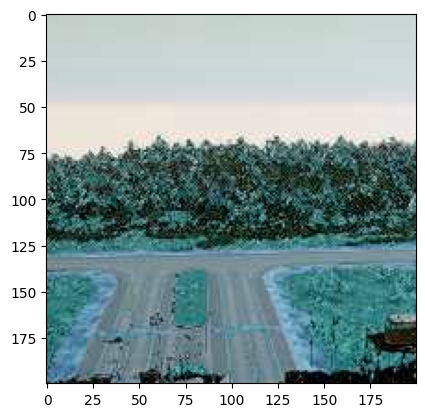

In [19]:
depth_img[:230, 210:560]

plt.imshow(depth_img[:200, 250:450])

In [78]:
depth_img = depth_img[:,:,0]

In [79]:
np.min(depth_img)

5

In [80]:
np.max(depth_img)

80

# New Implemenation of World cordinate:

In [340]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import cv2

def load_calibration_data(calibration_file):
    calibration = np.load(calibration_file)
    calibration_data = {
        'camera_matrix': calibration['camera_matrix'],
        'dist_coeffs': calibration['dist_coeffs'],
        'rvecs': calibration['rvecs'],
        'tvecs': calibration['tvecs']
    }
    return calibration_data

def get_camera_extrinsic(drone_state):
    
    # drone position and orientation(NED)
    drone_pos = drone_state['position']
    drone_quat = drone_state['orientation']

    # Converting the drone's orientation into a rotation matrix
    drone_rot = R.from_quat([drone_quat['qx'], drone_quat['qy'], 
                            drone_quat['qz'], drone_quat['qw']]).as_matrix()

    # Camera position relative to the drone (Body to Camera)
    cam_offset = np.array([0, 0, 0.24])

    R_cam_to_body = np.array([[0, 0, 1],
                              [1, 0, 0],
                              [0, 1, 0]])
    
    # چرخش پیچ: دوربین به اندازه 25 درجه رو به پایین (در فضای دوربین حول محور x)
    R_pitch = R.from_euler('x', -25, degrees=True).as_matrix()
    
    # ترکیب تبدیل‌ها: ابتدا از دوربین به بدنه، سپس اعمال زاویه پیچ
    cam_rot_body = R_cam_to_body @ R_pitch
    
    # تبدیل به فضای جهانی
    cam_pos_world = drone_pos + drone_rot @ cam_offset
    cam_rot_world = drone_rot @ cam_rot_body
    
    return cam_rot_world, cam_pos_world

def undistorted_imgs(rgb_img, calibration_data):
    K = calibration_data['camera_matrix']
    D = calibration_data['dist_coeffs']

    # For RGB: Use undistort with default bilinear interpolation
    undistorted_rgb = cv2.undistort(rgb_img, K, D, None, K)
    # cv2.imwrite('D:/Lectures/Robot/final/FinalProject-v2/codes and tools/notebooks/undistorted_image.jpg', undistorted_rgb)

    return undistorted_rgb

def pixel_to_global_v1(bbox, depth_img, cam_rot, cam_pos, calibration_data):
    
    x_min, y_min, x_max, y_max = bbox
    # Image distortion correction
    u_center = int((x_min + x_max) / 2)
    v_center = int((y_min + y_max) / 2)
    # pts = cv2.undistortPoints(np.array([[u_center, v_center]]), calibration_data['camera_matrix'], calibration_data['dist_coeffs'])
    
    # u_corrected, v_corrected = pts[0][0]

    fx = calibration_data['camera_matrix'][0, 0]
    fy = calibration_data['camera_matrix'][1, 1]
    cx = calibration_data['camera_matrix'][0, 2]
    cy = calibration_data['camera_matrix'][1, 2]

    # Calculating the ray direction in camera coordinates
    print((int(v_center)-2,int(v_center)+2), (int(u_center)-2,int(u_center)+2))
    
    z_roi = depth_img[int(v_center)-2:int(v_center)+2, int(u_center)-2:int(u_center)+2]
    valid_depths = z_roi[(z_roi > 0) & (z_roi <= 80)]
    if len(valid_depths) == 0:
        raise ValueError("No valid depth values")
    z = np.median(valid_depths)
    
    x_cam = (u_center - cx) * z / fx
    y_cam = (v_center - cy) * z / fy
    point_cam = np.array([x_cam, y_cam, z])

    # Convert to global coordinates
    point_world = cam_rot @ point_cam + cam_pos
    return point_world

def pixel_to_global_with_depth(u, v, depth, cam_rot, cam_pos, calibration_data):
    
    z = depth

    K = calibration_data['camera_matrix']
    D = calibration_data['dist_coeffs']

    pts = cv2.undistortPoints(np.array([[u, v]], dtype=np.float32), K, D)
    u_corrected, v_corrected = pts[0][0]

    fx = K[0,0]
    fy = K[1,1]
    cx = K[0,2]
    cy = K[1,2]

    x_cam = (u_corrected - cx) * z / fx
    y_cam = (v_corrected - cy) * z / fy

    point_world = cam_rot @ np.array([x_cam, y_cam, z]) + cam_pos
    return point_world

def pixel_to_global_with_ground(u, v, cam_rot, cam_pos, calibration_data, ground_z=0):

    K = calibration_data['camera_matrix']
    D = calibration_data['dist_coeffs']
    pts = cv2.undistortPoints(np.array([[u, v]], dtype=np.float32), K, D)
    u_corrected, v_corrected = pts[0][0]

    fx = K[0,0]
    fy = K[1,1]
    cx = K[0,2]
    cy = K[1,2]

    # معادله خط: [X, Y, Z] = λ * [(u - cx)/fx, (v - cy)/fy, 1]
    # با شرط Z = ground_z
    λ = ground_z / 1.0  # (از رابطه Z = λ * 1)
    x_cam = λ * (u_corrected - cx)/fx
    y_cam = λ * (v_corrected - cy)/fy

    point_world = cam_rot @ np.array([x_cam, y_cam, ground_z]) + cam_pos
    return point_world

rgb_img = cv2.imread("D:/Lectures/Robot/final/FinalProject-v2/codes and tools/final/20_rgb.png", cv2.IMREAD_UNCHANGED)
depth_img = cv2.imread("D:/Lectures/Robot/final/FinalProject-v2/codes and tools/final/20_depth.png", cv2.IMREAD_UNCHANGED)
calibration_data = load_calibration_data("D:/Lectures/Robot/final/FinalProject-v2/cam_calib/camera_calibration.npz")

undistorted_rgb = undistorted_imgs(rgb_img, calibration_data)
detected_objects = []

# drone_pos = [-107.1527099609375, -50.22417068481445, -34.608821868896484]
# drone_orientation_quat = {'qx': -3.24801317e-05,  'qy': 1.28950613e-04, 
#                           'qz': -6.74300761e-01, 'qw': 7.38456814e-01}
drone_pos = [
            -224.58949279785156,
            -105.0,
            -14.227203369140625
        ]

drone_orientation_quat = {'qx': 5.5179225067814974e-09,  'qy': 0.00037376430899679046, 
                          'qz': 1.1221925318375406e-07, 'qw': 0.9999999301501119}


drone_state = {'position': drone_pos,
               'orientation': drone_orientation_quat}

detections = detect_objects(rgb_img)

cam_rot, cam_pos = get_camera_extrinsic(drone_state)

for det in detections:
    x1, y1, x2, y2 = det['bbox']
    u_center = int((x1 + x2) / 2)
    v_center = int((y1 + y2) / 2)

    depth = depth_img[v_center, u_center]
    pos = pixel_to_global_v1(det['bbox'], depth_img, cam_rot, cam_pos, calibration_data)
    # pos = pixel_to_global_with_depth(u_center, v_center, depth, cam_rot, cam_pos, calibration_data)
    # pos = pixel_to_global_with_ground(u_center, v_center, cam_rot, cam_pos, calibration_data)

    detected_objects.append({'class': det['class'], 'position': pos})


# pos = pixel_to_global(bounding_box, depth_img, cam_rot, cam_pos, calibration_data)


0: 352x640 1 car, 70.0ms
Speed: 12.2ms preprocess, 70.0ms inference, 4.0ms postprocess per image at shape (1, 3, 352, 640)
(92, 96) (491, 495)


In [341]:
pos

array([    -164.58,      -78.12,     -5.4736])

In [324]:
detected_objects

[{'class': 'person',
  'position': array([    -317.72,      -72.59,    -0.28497])}]

In [120]:
calibration_data['camera_matrix']

array([[     284.08,           0,      361.34],
       [          0,      282.95,      179.87],
       [          0,           0,           1]])

In [ ]:
model = YOLO("D:/Lectures/Robot/final/FinalProject-v2/codes and tools/models/best.pt") 

# Train the model on your dataset
model.train(data="data.yaml", epochs=50, imgsz=640, batch=16, device=0)

In [270]:
import cv2

# خواندن تصویر
image = cv2.imread('D:/Lectures/Robot/final/FinalProject-v2/codes and tools/notebooks/undistorted_image.jpg')

# تعیین مختصات جعبه
x1, x2 = 399, 403  # محدوده‌ی افقی
y1, y2 = 280, 284  # محدوده‌ی عمودی

# رنگ جعبه (BGR format)
color = (0, 255, 0)  # سبز

# ضخامت خط جعبه
thickness = 2

# رسم جعبه روی تصویر
cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)

# نمایش تصویر با جعبه
cv2.imshow('Image with Box', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# ذخیره تصویر با جعبه (اختیاری)
cv2.imwrite('D:/Lectures/Robot/final/FinalProject-v2/codes and tools/notebooks/output_undistored_image.jpg', image)

True

In [359]:
import math

# Example: given point (x, y, z) 
given_point = (10, 20, 30)  # replace with your actual point

# Example list of dictionaries (each detection)
detections = [
    {
        'img_id': 1,
        'class': 'car', 
        'position': [12, 24, 0],  # example position as a list [x, y, z]
        'cam_pos': [0, 0, 0],
        'drone_pos': [0, 0, 0],
        'dron_ori': [0, 0, 0, 1],
        'bbox': [100, 150, 200, 250]
    },
    {
        'img_id': 2,
        'class': 'pedestrian', 
        'position': [15, 18, 0],
        'cam_pos': [0, 0, 0],
        'drone_pos': [0, 0, 0],
        'dron_ori': [0, 0, 0, 1],
        'bbox': [50, 75, 100, 125]
    },
    # Add more dictionaries as needed
]

def euclidean_distance_2d(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)


given_point_xy = (given_point[0], given_point[1])

# Compute and print distances for each detection
for det in detections:
    # Assuming 'position' is stored as a list like [x, y, z]
    det_position = det['position']
    det_position_xy = (det_position[0], det_position[1])
    
    distance = euclidean_distance_2d(given_point_xy, det_position_xy)
    print(f"Distance from point {given_point_xy} to detection {det['img_id']} at {det_position_xy} is: {distance:.2f}")


Distance from point (10, 20) to detection 1 at (12, 24) is: 4.47
Distance from point (10, 20) to detection 2 at (15, 18) is: 5.39


### Yolo visdrone fine tune

In [1]:
from ultralytics import YOLO

# Load a model
model = YOLO("D:/Lectures/Robot/final/FinalProject-code/codes and tools/models/best.pt")


In [2]:
results = model("D:/Lectures/Robot/final/FinalProject-code/codes and tools/notebooks/rgb_img1.png")


image 1/1 D:\Lectures\Robot\final\FinalProject-code\codes and tools\notebooks\rgb_img1.png: 352x640 2 cars, 46.8ms
Speed: 0.0ms preprocess, 46.8ms inference, 231.1ms postprocess per image at shape (1, 3, 352, 640)


In [3]:
results[0].show()

# Final plot

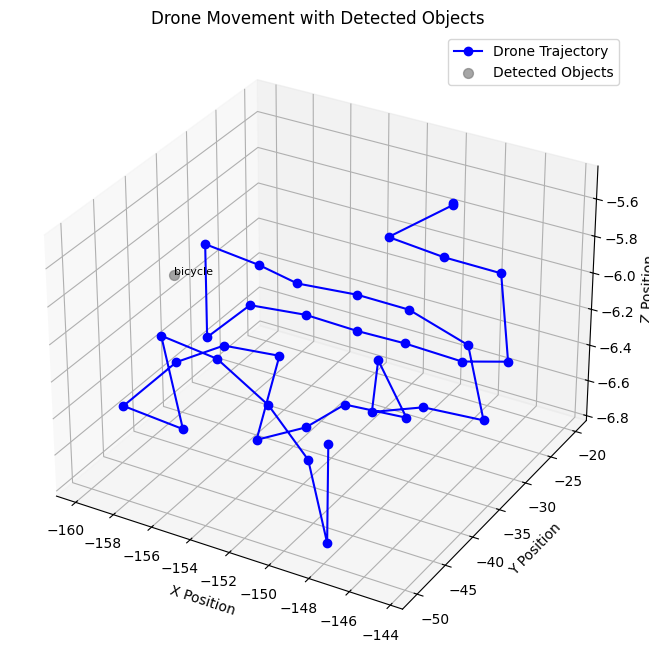

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load drone movement data from CSV
csv_file = "D:/Lectures/Robot/final/FinalProject-code/data_with_timestamp_2.csv"
drone_data = pd.read_csv(csv_file)

# Extract drone positions for plotting
drone_x = drone_data['0'].values
drone_y = drone_data['1'].values
drone_z = drone_data['2'].values

# Load detected objects data from JSON
json_file = "D:/Lectures/Robot/final/FinalProject-code/samples_2.json"
with open(json_file, 'r') as f:
    detected_objects = json.load(f)

# Extract detected objects' positions and class labels
object_positions = []
for obj in detected_objects:
    object_positions.append({
        'position': obj['position'],
        'class': obj['class']
    })

# Separate detected objects' positions and class labels
object_x = [obj['position'][0] for obj in object_positions]
object_y = [obj['position'][1] for obj in object_positions]
object_z = [obj['position'][2] for obj in object_positions]
object_classes = [obj['class'] for obj in object_positions]

# Define colors for different object classes
class_colors = {
    "car": "red",
    "person": "green",
    "unknown": "gray"  
}

# Assign colors based on object classes
object_colors = [class_colors.get(cls, "gray") for cls in object_classes]

# Plot the drone's trajectory and detected objects
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot drone trajectory
ax.plot(drone_x, drone_y, drone_z, label='Drone Trajectory', color='blue', linestyle='-', marker='o')

# Plot detected objects
scatter = ax.scatter(object_x, object_y, object_z, c=object_colors, s=50, alpha=0.7, label='Detected Objects')

# Annotate each detected object with its class label
for i, obj in enumerate(object_positions):
    ax.text(obj['position'][0], obj['position'][1], obj['position'][2],
            obj['class'], color='black', fontsize=8)

# Add labels and legend
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.legend()
ax.set_title('Drone Movement with Detected Objects')

# Show the plot
plt.show()

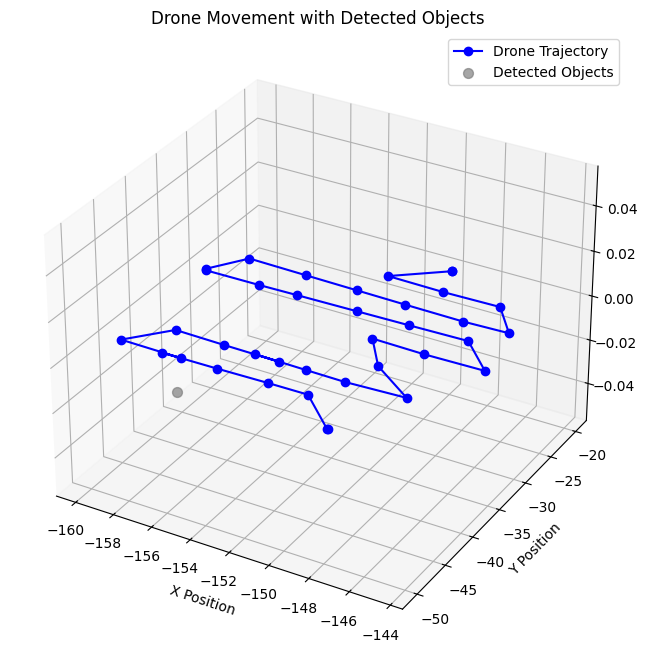

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load drone movement data from CSV
csv_file = "D:/Lectures/Robot/final/FinalProject-code/data_with_timestamp_2.csv"
drone_data = pd.read_csv(csv_file)

# Extract drone positions for plotting
drone_x = drone_data['0'].values
drone_y = drone_data['1'].values
# drone_z = drone_data['2'].values

# Load detected objects data from JSON
json_file = "D:/Lectures/Robot/final/FinalProject-code/samples_2.json"
with open(json_file, 'r') as f:
    detected_objects = json.load(f)

# Extract detected objects' positions and class labels
object_positions = []
for obj in detected_objects:
    object_positions.append({
        'position': obj['position'],
        'class': obj['class']
    })

# Separate detected objects' positions and class labels
object_x = [obj['position'][0] for obj in object_positions]
object_y = [obj['position'][1] for obj in object_positions]
# object_z = [obj['position'][2] for obj in object_positions]
object_classes = [obj['class'] for obj in object_positions]

# Define colors for different object classes
class_colors = {
    "car": "red",
    "person": "green",
    "truck": "blue",
    "unknown": "gray"  # Default color for unknown classes
}

# Assign colors based on object classes
object_colors = [class_colors.get(cls, "gray") for cls in object_classes]

# Plot the drone's trajectory and detected objects
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot drone trajectory
ax.plot(drone_x, drone_y, label='Drone Trajectory', color='blue', linestyle='-', marker='o')

# Plot detected objects
scatter = ax.scatter(object_x, object_y, c=object_colors, s=50, alpha=0.7, label='Detected Objects')

# Annotate each detected object with its class label
for i, obj in enumerate(object_positions):
    ax.text(obj['position'][0], obj['position'][1], obj['position'][2],
            obj['class'], color='black', fontsize=8)

# Add labels and legend
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
# ax.set_zlabel('Z Position')
ax.legend()
ax.set_title('Drone Movement with Detected Objects')

# Show the plot
plt.show()